# Sentiment Distribution Across Analyses

This notebook reads `data/sentiment-analysis-all.csv` and creates:
- A chart showing the distribution of Positive, Neutral, and Negative labels across different analysis methods (Manual, TextBlob, AFINN, VADER, ChatGPT, Claude).
- Two small exploratory charts: (a) positive reviews mentioning "taste" and (b) negative reviews mentioning "leak" or "crack".

Each step is kept small, with explanations between code snippets.

## 1. Setup and Imports

Install and import the packages used in this notebook, and set a consistent plotting style.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('ggplot')
sns.set_palette('bright')

## 2. Load Input Data

We load the consolidated CSV (`data/sentiment-analysis-all.csv`) that includes manual and automated sentiment labels and the original review text.

In [8]:
# Paths
repo_root = Path('.')
csv_path = repo_root / 'data' / 'sentiment-analysis-all.csv'

# Load data
df = pd.read_csv(csv_path)
print(f"Loaded {len(df)} rows from {csv_path}")

Loaded 50 rows from data/sentiment-analysis-all.csv


## 3. Define Label Columns and Normalization Helper

Different sources may use slightly different casing/spacing. We normalize labels to one of {Positive, Neutral, Negative}. If a column is missing, we fill it with NAs to keep shapes aligned.

In [9]:
# Columns that hold categorical labels for each analysis
label_cols = [
    "Lawrence's Manual Label",
    "TextBlob Label",
    "AFINN Label",
    "Vader",
    "ChatGPT",
    "Claude",
]

# Normalize case/spacing to one of {Positive, Neutral, Negative} where possible
def normalize_label(x):
    if pd.isna(x):
        return pd.NA
    s = str(x).strip().capitalize()
    if s.startswith('pos'):
        return 'Positive'
    if s.startswith('neu'):
        return 'Neutral'
    if s.startswith('neg'):
        return 'Negative'
    # Fall back to original if matches exactly
    if s in {'Positive','Neutral','Negative'}:
        return s
    return pd.NA

## 4. Build a Clean Labels DataFrame

Apply normalization to each available label column. If a column is absent from the CSV, create an all-NA Series to avoid KeyErrors. This produces `labels_df` with clean labels.

In [10]:
normalized = {}
for col in label_cols:
    # Some columns may be entirely empty; handle safely
    if col in df.columns:
        normalized[col] = df[col].map(normalize_label)
    else:
        # If missing, create NA series to avoid KeyErrors
        normalized[col] = pd.Series([pd.NA]*len(df))

labels_df = pd.DataFrame(normalized)
labels_df.head()

,Lawrence's Manual Label,TextBlob Label,AFINN Label,Vader,ChatGPT,Claude
0,Positive,Positive,Positive,Positive,Positive,Positive
1,Neutral,Neutral,Positive,Positive,Neutral,Neutral
2,Negative,Negative,Negative,Negative,Negative,Negative
3,Positive,Positive,Positive,Positive,Positive,Positive
4,Neutral,Negative,Positive,Neutral,Neutral,Neutral


## 5. Compute Distribution by Analysis

Count Positive/Neutral/Negative per analysis and reshape for plotting.

In [11]:
# Count distribution per analysis
order_sentiments = ['Positive', 'Neutral', 'Negative']
counts = (
    labels_df.apply(lambda s: s.value_counts()).fillna(0).astype(int)
    .reindex(index=order_sentiments)
)

# Melt for seaborn grouped barplot
plot_df = counts.reset_index().rename(columns={'index': 'Sentiment'})
plot_df = plot_df.melt(id_vars='Sentiment', var_name='Analysis', value_name='Count')
plot_df.head()

,Sentiment,Analysis,Count
0,Positive,Lawrence's Manual Label,29
1,Neutral,Lawrence's Manual Label,11
2,Negative,Lawrence's Manual Label,10
3,Positive,TextBlob Label,34
4,Neutral,TextBlob Label,9


## 6. Plot and Save: Distribution Across Analyses

Create a grouped bar plot and save it to `data/sentiment_distribution_across_analyses.png`.

Saved figure to data/sentiment_distribution_across_analyses.png


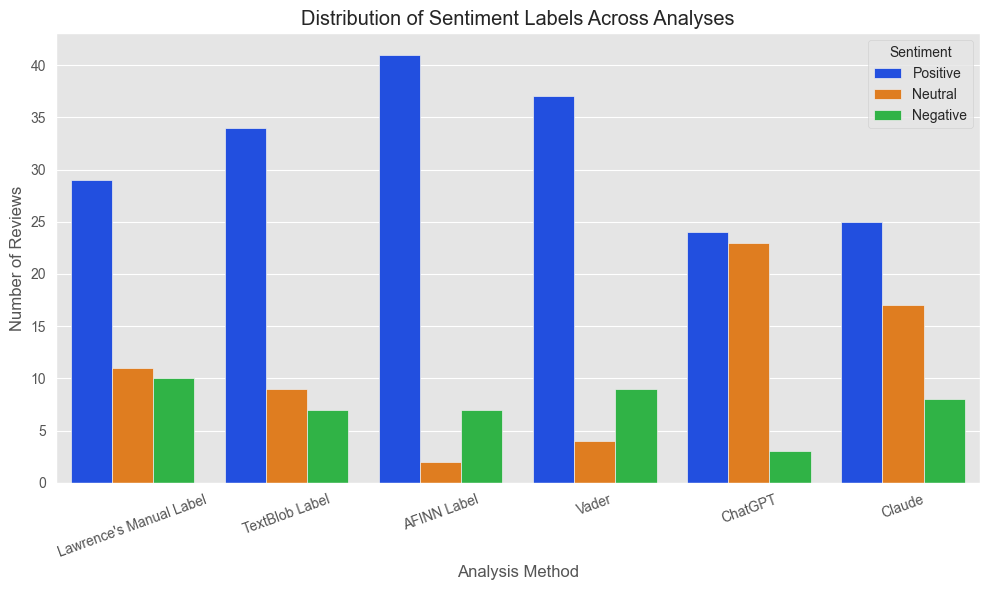

In [12]:
# Plot
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=plot_df, x='Analysis', y='Count', hue='Sentiment', ax=ax)
ax.set_title('Distribution of Sentiment Labels Across Analyses')
ax.set_xlabel('Analysis Method')
ax.set_ylabel('Number of Reviews')
ax.legend(title='Sentiment')
plt.xticks(rotation=20)
plt.tight_layout()

# Save figure
fig_dir = repo_root / 'data'
fig_dir.mkdir(parents=True, exist_ok=True)
out_path = fig_dir / 'sentiment_distribution_across_analyses.png'
plt.savefig(out_path, dpi=200)
print(f"Saved figure to {out_path}")

## 7. Exploratory: Positive Reviews Mentioning "taste"

We examine, for each analysis method, how many reviews labeled Positive include the word "taste" (case-insensitive). This can hint at topical drivers of positive sentiment.

In [13]:
# Count how many positive reviews contain the word "taste"
taste_in_positive = {}

# For each analysis method
for col in label_cols:
    # Filter reviews that were labeled as positive
    positive_reviews = df[labels_df[col] == 'Positive']

    # Count how many of these positive reviews contain the word "taste"
    taste_count = positive_reviews['Review Text'].str.contains('taste', case=False, na=False).sum()

    # Store the count
    taste_in_positive[col] = taste_count

# Create a DataFrame for plotting
taste_df = pd.DataFrame({'Analysis': list(taste_in_positive.keys()),
                         'Positive Reviews with "taste"': list(taste_in_positive.values())})
taste_df

,Analysis,"Positive Reviews with ""taste"""
0,Lawrence's Manual Label,12
1,TextBlob Label,14
2,AFINN Label,17
3,Vader,16
4,ChatGPT,11
5,Claude,12


## 8. Plot and Save: Positive with "taste"

Save to `data/positive_reviews_with_taste.png`.

Saved figure to data/positive_reviews_with_taste.png


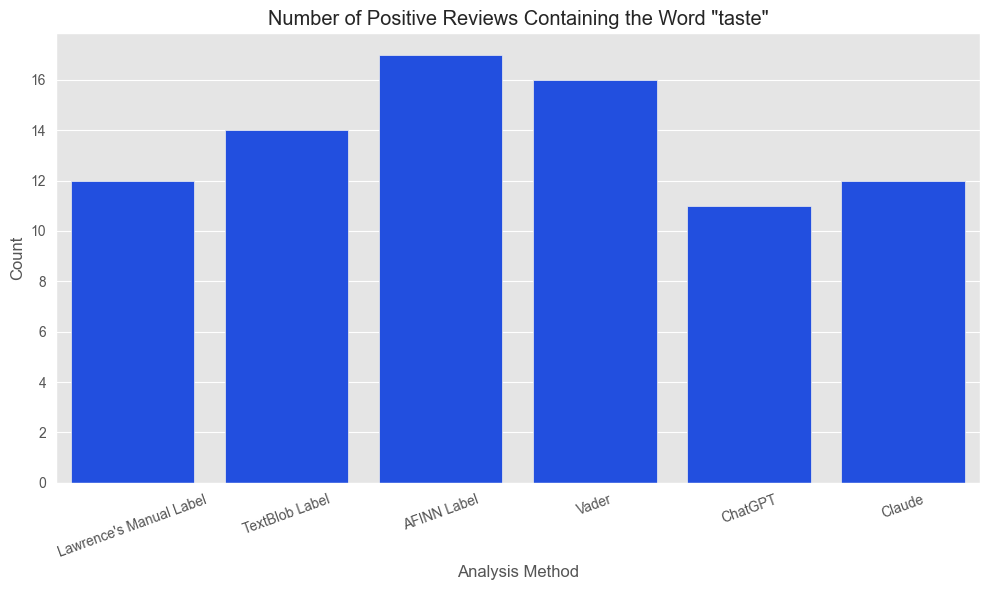

In [14]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Analysis', y='Positive Reviews with "taste"', data=taste_df)
plt.title('Number of Positive Reviews Containing the Word "taste"')
plt.xlabel('Analysis Method')
plt.ylabel('Count')
plt.xticks(rotation=20)
plt.tight_layout()

# Save figure
taste_fig_path = fig_dir / 'positive_reviews_with_taste.png'
plt.savefig(taste_fig_path, dpi=200)
print(f"Saved figure to {taste_fig_path}")

## 9. Exploratory: Negative Reviews Mentioning "leak" or "crack"

Similarly, we check the number of Negative-labeled reviews that mention potential product defects: "leak" or "crack" (case-insensitive).

In [15]:
# Count how many negative reviews contain the words "leak" or "crack"
leak_crack_in_negative = {}

# For each analysis method
for col in label_cols:
    # Filter reviews that were labeled as negative
    negative_reviews = df[labels_df[col] == 'Negative']

    # Count how many of these negative reviews contain the words "leak" or "crack"
    leak_crack_count = negative_reviews['Review Text'].str.contains('leak|crack', case=False, na=False).sum()

    # Store the count
    leak_crack_in_negative[col] = leak_crack_count

# Create a DataFrame for plotting
leak_crack_df = pd.DataFrame({
    'Analysis': list(leak_crack_in_negative.keys()),
    'Negative Reviews with "leak" or "crack"': list(leak_crack_in_negative.values())
})
leak_crack_df

,Analysis,"Negative Reviews with ""leak"" or ""crack"""
0,Lawrence's Manual Label,3
1,TextBlob Label,3
2,AFINN Label,3
3,Vader,3
4,ChatGPT,1
5,Claude,3


## 10. Plot and Save: Negative with "leak" or "crack"

Save to `data/negative_reviews_with_leak_or_crack.png`.

Saved figure to data/negative_reviews_with_leak_or_crack.png


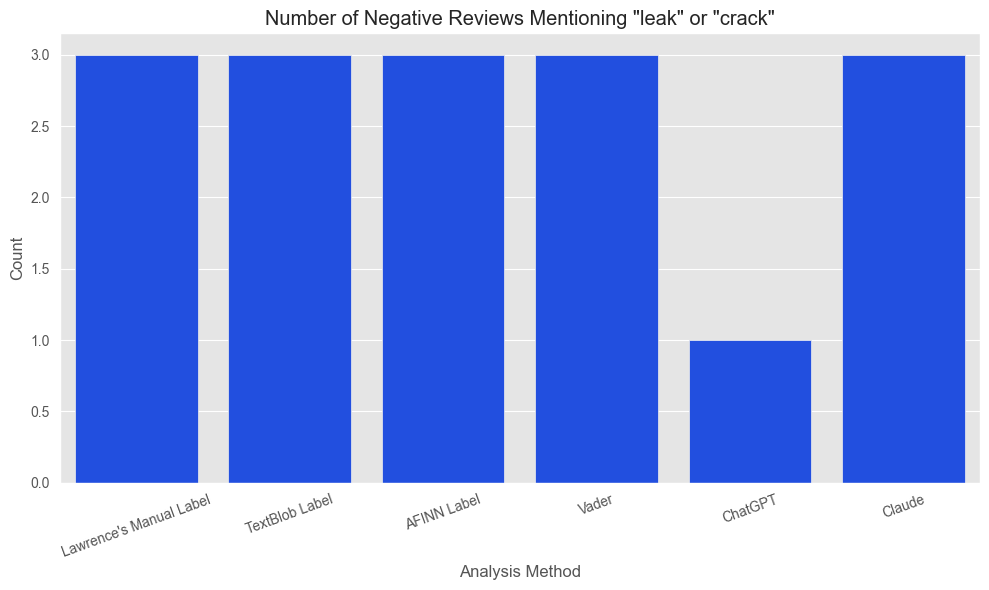

In [16]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Analysis', y='Negative Reviews with "leak" or "crack"', data=leak_crack_df)
plt.title('Number of Negative Reviews Mentioning "leak" or "crack"')
plt.xlabel('Analysis Method')
plt.ylabel('Count')
plt.xticks(rotation=20)
plt.tight_layout()

# Save figure
leak_crack_fig_path = fig_dir / 'negative_reviews_with_leak_or_crack.png'
plt.savefig(leak_crack_fig_path, dpi=200)
print(f"Saved figure to {leak_crack_fig_path}")
